Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Epoch 1/200
334/334 [==============================] - 227s 667ms/step - loss: 2.0231 - accuracy: 0.2336 - val_loss: 1.7551 - val_accuracy: 0.3545 - lr: 0.0010
Epoch 2/200
334/334 [==============================] - 221s 660ms/step - loss: 1.6034 - accuracy: 0.4119 - val_loss: 1.4489 - val_accuracy: 0.4775 - lr: 0.0010
Epoch 3/200
334/334 [==============================] - 223s 667ms/step - loss: 1.3887 - accuracy: 0.4994 - val_loss: 1.2964 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 4/200
334/334 [==============================] - 204s 610ms/step - loss: 1.1656 - accuracy: 0.5901 - val_loss: 1.0544 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 5/200
334/334 [==============================] - 221s 659ms/step - loss: 0.9964 - accuracy: 0.6502 - val_loss: 0.9172 - val_accuracy: 0.6760 - lr: 0.0010
Epoch 6/200
334/334 [==============================] - 221s 659ms/step - loss: 0.8536 - accuracy: 0.7038 - val_lo

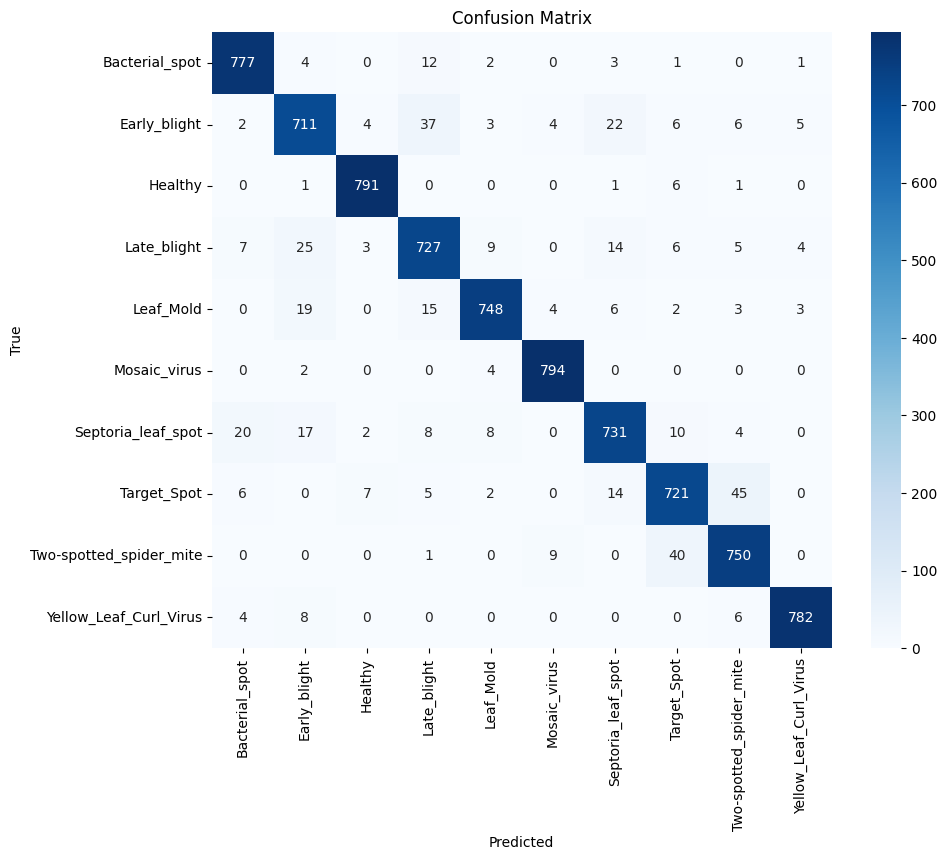

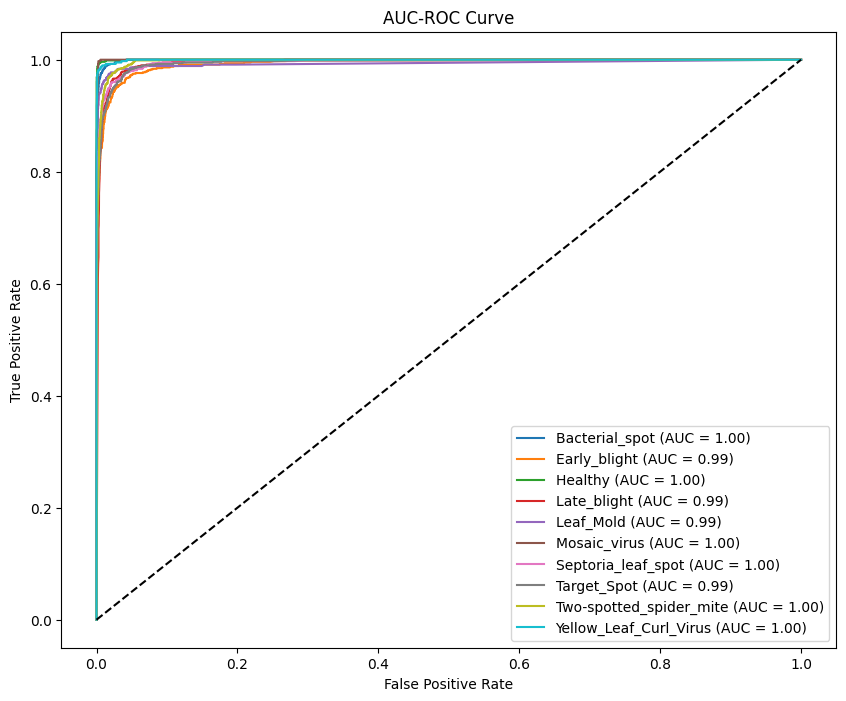

Trainable parameters: 521698
Non-trainable parameters: 0
Total training time: 275.63 minutes


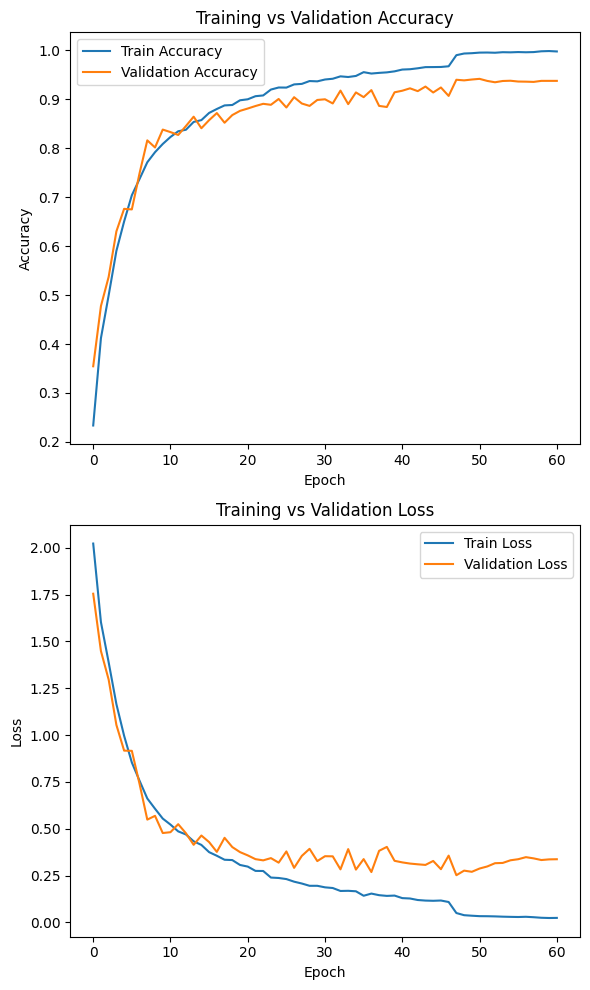

In [2]:
#Ablation study 1#Model A (With CAL)#Tawawa
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress only the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import backend as K
# Dataset path and config
dataset_dir = "TomatoResizedCLAHE122Augmented4000"
img_size = (224, 224)
batch_size = 96
num_classes = 10
input_shape = (224, 224, 3)
# Data generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                              class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                            class_mode="categorical", subset="validation", shuffle=False)
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
#############################################################################################
def attention_block(x):
    attn = layers.GlobalAveragePooling2D()(x)
    attn = layers.Dense(x.shape[-1] // 8, activation="relu")(attn)
    attn = layers.Dense(x.shape[-1], activation="sigmoid")(attn)
    return layers.Multiply()([x, attn])

def residual_block(x, filters):
    res = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    res = layers.Conv2D(filters, (3, 3), padding="same")(res)
    res = layers.Add()([x, res])
    return layers.Activation("relu")(res)

def model_with_cal(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 64)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 128)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = model_with_cal(input_shape, num_classes)
##################################################################################
start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=200,
                    callbacks=[early_stopping, reduce_lr])
model.save("King Saaud Tomato\\CustomTomatoModelWitthCALbatchsize.h5")
training_time = time.time() - start_time
##################################################################################
val_generator.reset()
val_pred = model.predict(val_generator, verbose=1)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
true_classes_binarized = label_binarize(true_classes, classes=range(num_classes))
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], val_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Parameter count
trainable_params = sum([K.count_params(p) for p in model.trainable_weights])
non_trainable_params = sum([K.count_params(p) for p in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")
print(f"Total training time: {training_time / 60:.2f} minutes")

# Plot Training and Validation Accuracy and Loss (Square-Shaped, Stacked Vertically)
def plot_training_curves(history):
    plt.figure(figsize=(6, 10))  # Narrower width for square appearance

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_curves(history)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Epoch 1/200
334/334 [==============================] - 528s 2s/step - loss: 2.0605 - accuracy: 0.2118 - val_loss: 1.7129 - val_accuracy: 0.3614 - lr: 0.0010
Epoch 2/200
334/334 [==============================] - 135s 404ms/step - loss: 1.7134 - accuracy: 0.3549 - val_loss: 1.5421 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 3/200
334/334 [==============================] - 459s 1s/step - loss: 1.5358 - accuracy: 0.4311 - val_loss: 1.3562 - val_accuracy: 0.4863 - lr: 0.0010
Epoch 4/200
334/334 [==============================] - 1877s 6s/step - loss: 1.3151 - accuracy: 0.5150 - val_loss: 1.1871 - val_accuracy: 0.5665 - lr: 0.0010
Epoch 5/200
334/334 [==============================] - 1477s 4s/step - loss: 1.1594 - accuracy: 0.5762 - val_loss: 1.0359 - val_accuracy: 0.6220 - lr: 0.0010
Epoch 6/200
334/334 [==============================] - 1464s 4s/step - loss: 1.0317 - accuracy: 0.6304 - val_loss: 0.9014 -

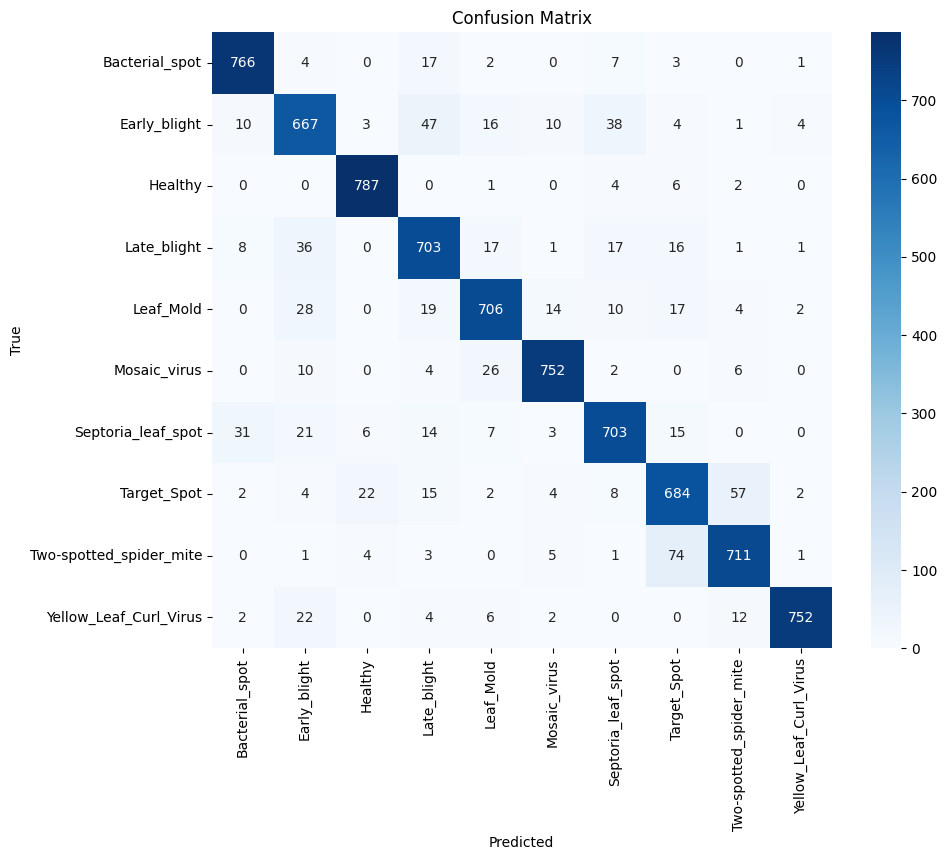

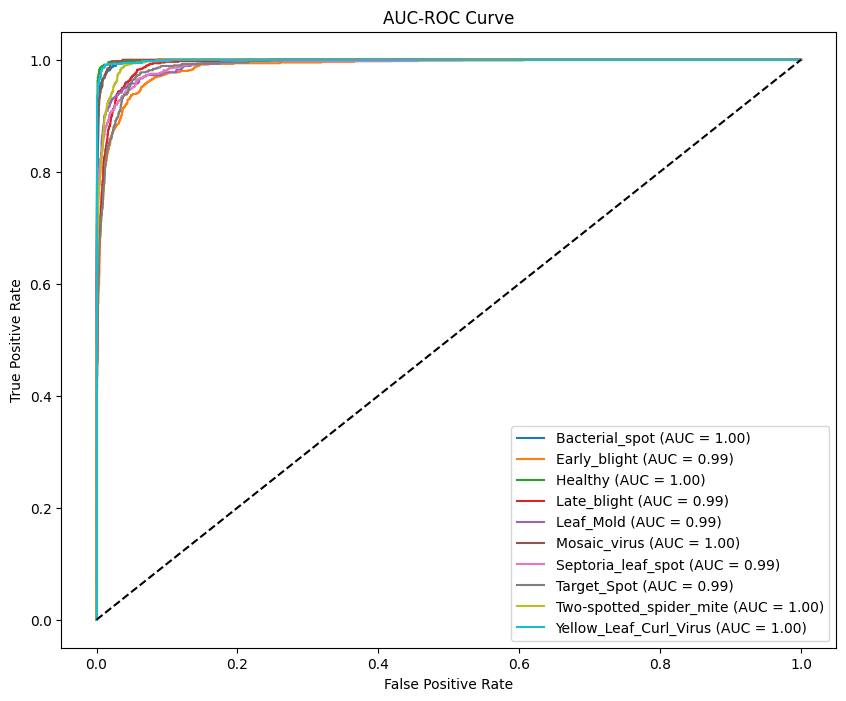

Trainable parameters: 516362
Non-trainable parameters: 0
Total training time: 870.63 minutes


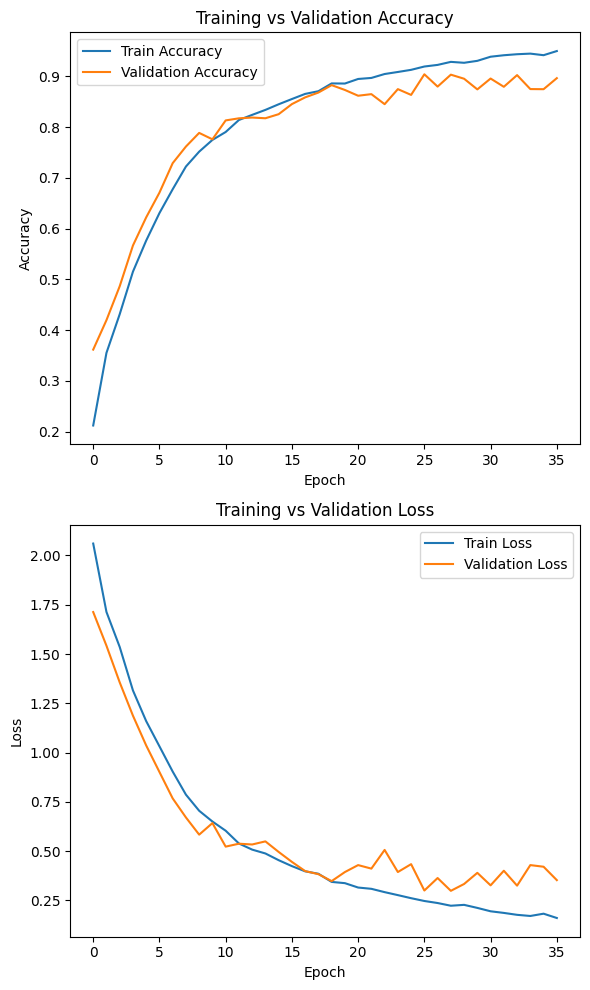

In [5]:
#Ablation study 2#Model B (Without CAL)96
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress only the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import backend as K
# Dataset path and config
dataset_dir = "TomatoResizedCLAHE122Augmented4000"
img_size = (224, 224)
batch_size = 96
num_classes = 10
input_shape = (224, 224, 3)
# Data generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                              class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                            class_mode="categorical", subset="validation", shuffle=False)
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
################################################################################
def model_without_cal(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 64)
    # No CAL here
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 128)
    # No CAL here
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = model_without_cal(input_shape, num_classes)
###########################################################################
start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=200,
                    callbacks=[early_stopping, reduce_lr])
model.save("King Saaud Tomato\\CustomTomatoModelWithoutCAL96.h5")
training_time = time.time() - start_time
############################################################################
val_generator.reset()
val_pred = model.predict(val_generator, verbose=1)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
true_classes_binarized = label_binarize(true_classes, classes=range(num_classes))
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], val_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Parameter count
trainable_params = sum([K.count_params(p) for p in model.trainable_weights])
non_trainable_params = sum([K.count_params(p) for p in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")
print(f"Total training time: {training_time / 60:.2f} minutes")



# Plot Training and Validation Accuracy and Loss (Stacked Vertically)
# Plot Training and Validation Accuracy and Loss (Square-Shaped, Stacked Vertically)
def plot_training_curves(history):
    plt.figure(figsize=(6, 10))  # Narrower width for square appearance

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_curves(history)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 224, 224, 32  9248        ['conv2d_12[0][0]']              
     

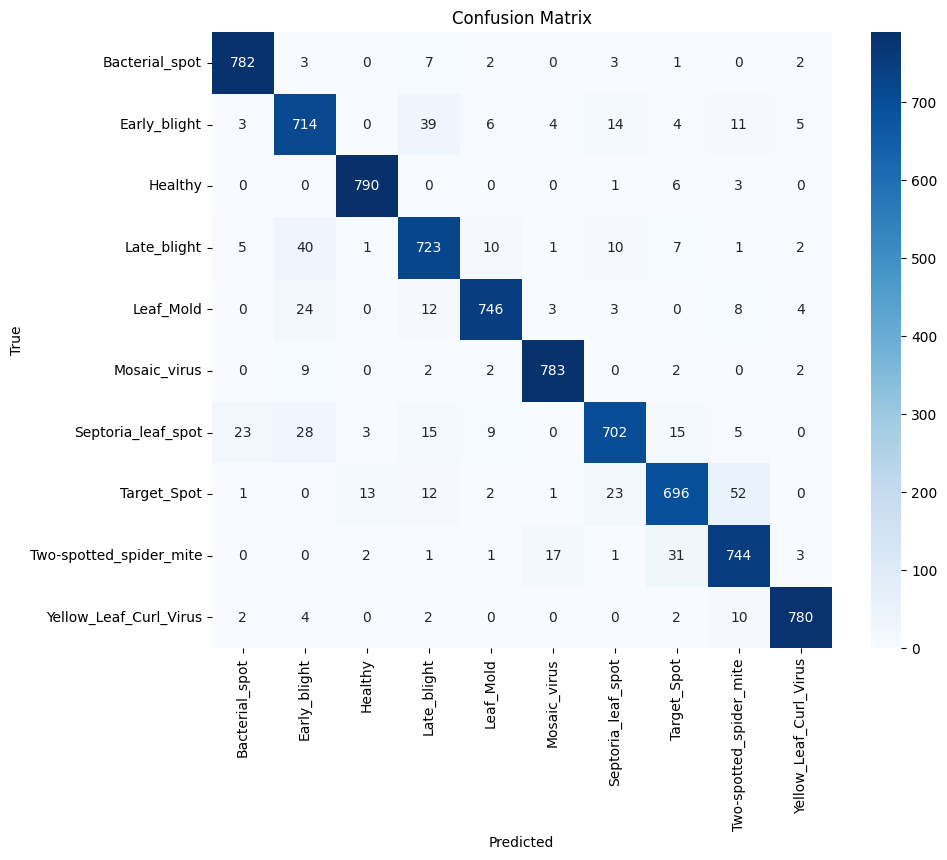

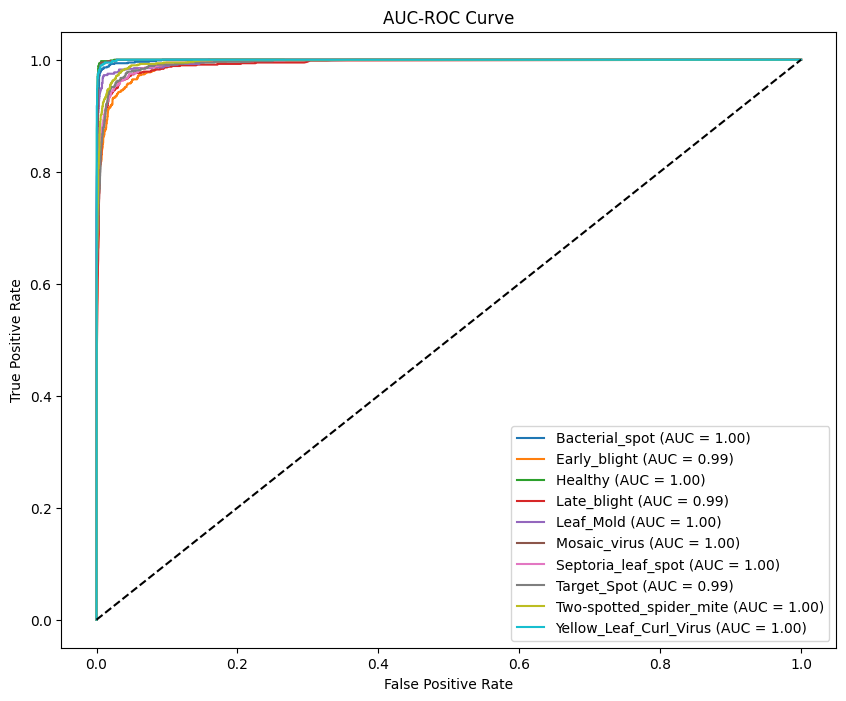

Trainable parameters: 327938
Non-trainable parameters: 0
Total training time: 199.76 minutes


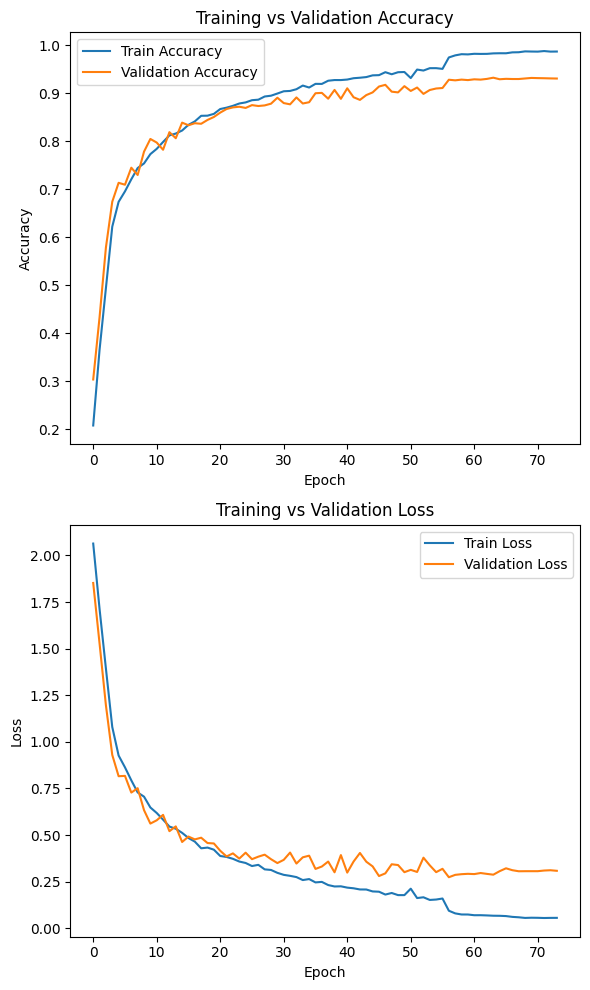

In [6]:
#Model Without Residual Connections (Only Conv → CAL)96Tawawa
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress only the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import backend as K
# Dataset path and config
dataset_dir = "TomatoResizedCLAHE122Augmented4000"
img_size = (224, 224)
batch_size = 96
num_classes = 10
input_shape = (224, 224, 3)
# Data generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                              class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                            class_mode="categorical", subset="validation", shuffle=False)
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
from tensorflow.keras import layers, models, regularizers

def attention_block(x):
    attn = layers.GlobalAveragePooling2D()(x)
    attn = layers.Dense(x.shape[-1] // 8, activation="relu")(attn)
    attn = layers.Dense(x.shape[-1], activation="sigmoid")(attn)
    return layers.Multiply()([x, attn])

def model_without_residual(input_shape=(224, 224, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Conv Block 2 + CAL
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Conv Block 3 + CAL
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model = model_without_residual(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()  
###########################################################################
start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=200,
                    callbacks=[early_stopping, reduce_lr])
model.save("King Saaud Tomato\\CustomTomatoModelWithoutResidualblock96.h5")
training_time = time.time() - start_time
############################################################################
val_generator.reset()
val_pred = model.predict(val_generator, verbose=1)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
true_classes_binarized = label_binarize(true_classes, classes=range(num_classes))
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], val_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Parameter count
trainable_params = sum([K.count_params(p) for p in model.trainable_weights])
non_trainable_params = sum([K.count_params(p) for p in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")
print(f"Total training time: {training_time / 60:.2f} minutes")

# Plot Training and Validation Accuracy and Loss (Stacked Vertically)
# Plot Training and Validation Accuracy and Loss (Square-Shaped, Stacked Vertically)
def plot_training_curves(history):
    plt.figure(figsize=(6, 10))  # Narrower width for square appearance

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_curves(history)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080 Laptop GPU, compute capability 8.9
Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                   

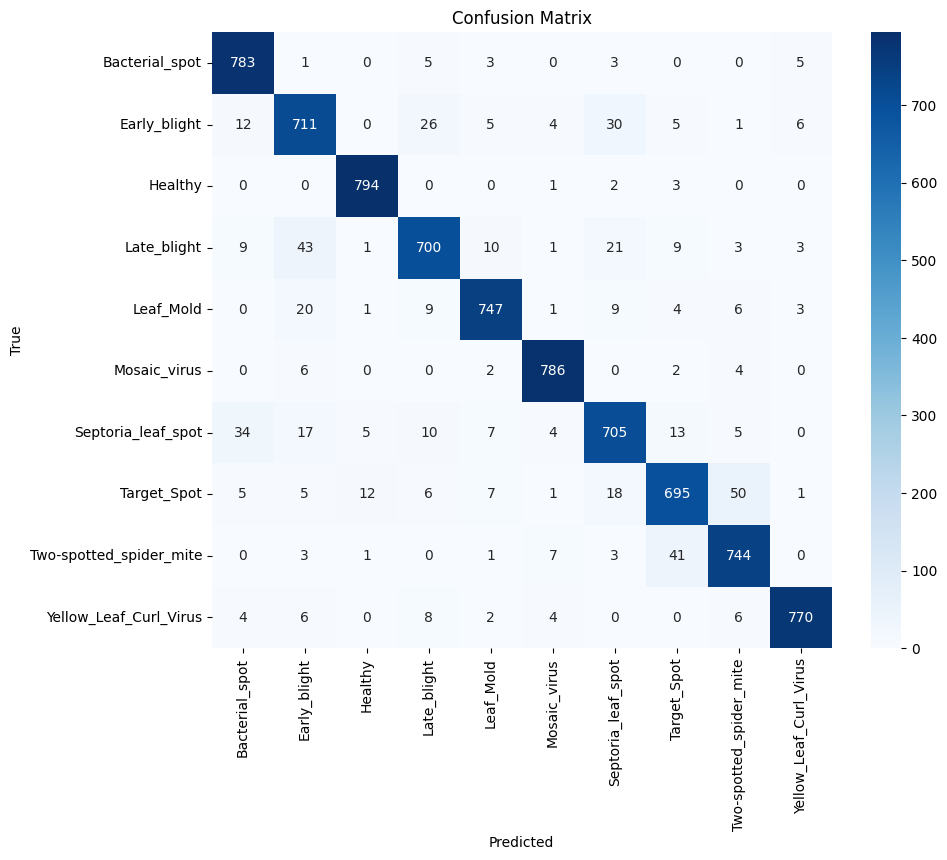

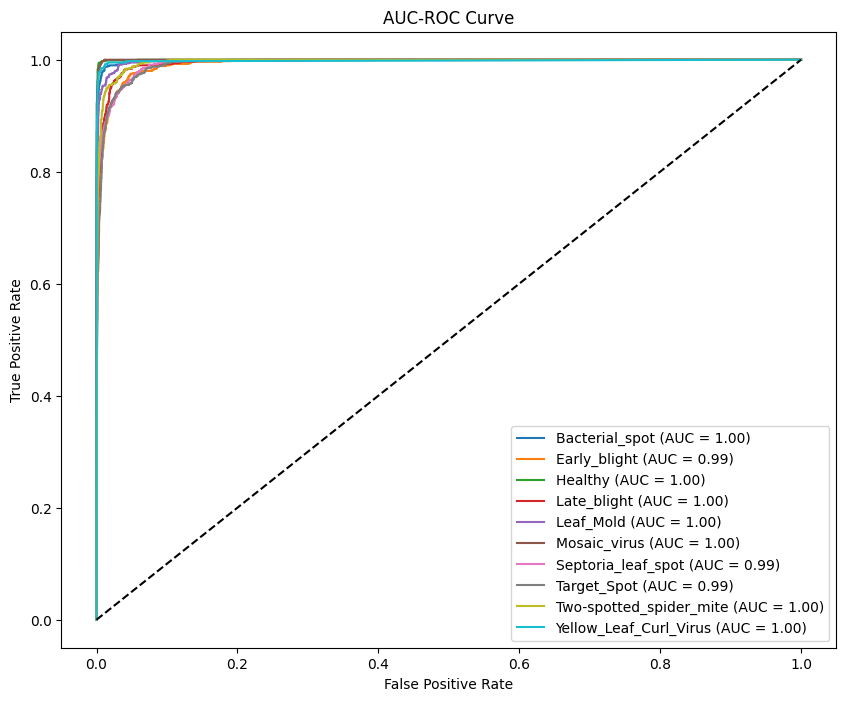

Trainable parameters: 521698
Non-trainable parameters: 0
Total training time: 178.72 minutes


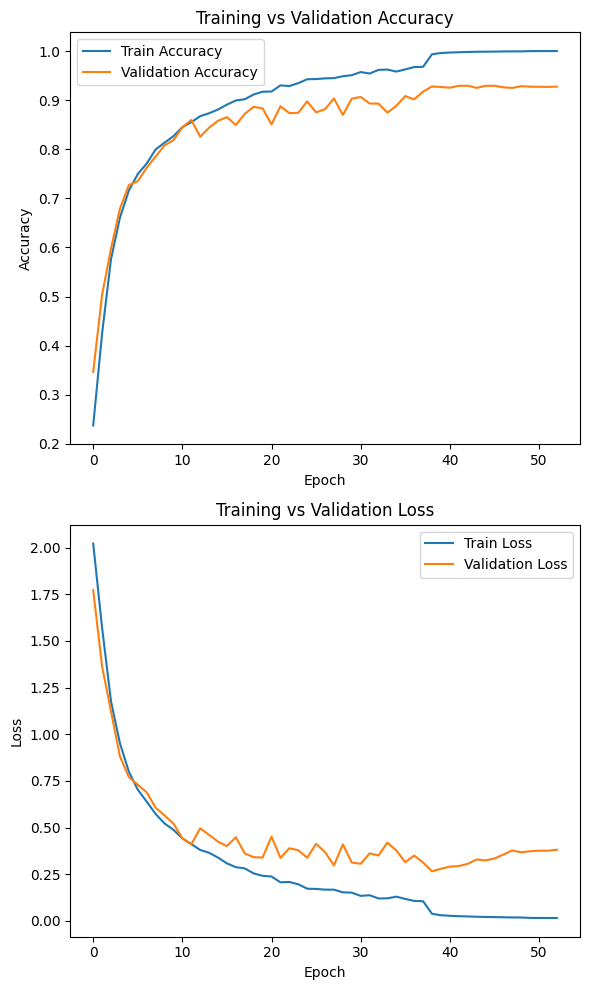

In [1]:
#Model Without Dropout (CAL and Residual Connections Kept)96#Tawawa
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress only the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import backend as K
# Dataset path and config
dataset_dir = "TomatoResizedCLAHE122Augmented4000"
img_size = (224, 224)
batch_size = 96
num_classes = 10
input_shape = (224, 224, 3)
# Data generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                              class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                            class_mode="categorical", subset="validation", shuffle=False)
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
from tensorflow.keras import layers, models, regularizers

def attention_block(x):
    attn = layers.GlobalAveragePooling2D()(x)
    attn = layers.Dense(x.shape[-1] // 8, activation="relu")(attn)
    attn = layers.Dense(x.shape[-1], activation="sigmoid")(attn)
    return layers.Multiply()([x, attn])

def residual_block(x, filters):
    res = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    res = layers.Conv2D(filters, (3, 3), padding="same")(res)
    res = layers.Add()([x, res])
    return layers.Activation("relu")(res)

def model_without_dropout(input_shape=(224, 224, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    # Conv Block 2 + CAL
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 64)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Conv Block 3 + CAL
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 128)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Classification head (no Dropout)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model = model_without_dropout(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()

start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=200,
                    callbacks=[early_stopping, reduce_lr])
model.save("King Saaud Tomato\\CustomTomatoModelWithoutDropout96.h5")
training_time = time.time() - start_time
############################################################################
val_generator.reset()
val_pred = model.predict(val_generator, verbose=1)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
true_classes_binarized = label_binarize(true_classes, classes=range(num_classes))
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], val_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Parameter count
trainable_params = sum([K.count_params(p) for p in model.trainable_weights])
non_trainable_params = sum([K.count_params(p) for p in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")
print(f"Total training time: {training_time / 60:.2f} minutes")
# Plot Training and Validation Accuracy and Loss (Square-Shaped, Stacked Vertically)
def plot_training_curves(history):
    plt.figure(figsize=(6, 10))  # Narrower width for square appearance

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Call the function
plot_training_curves(history)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 224, 224, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 224, 224, 32  9248        ['conv2d_27[0][0]']              
     

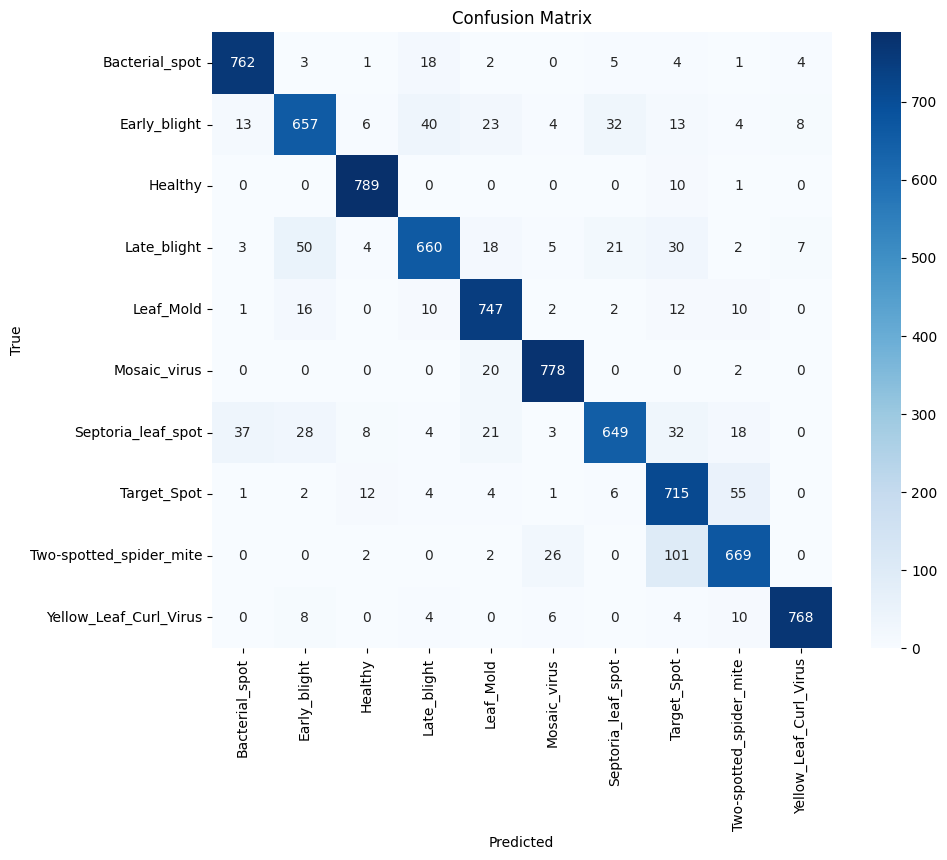

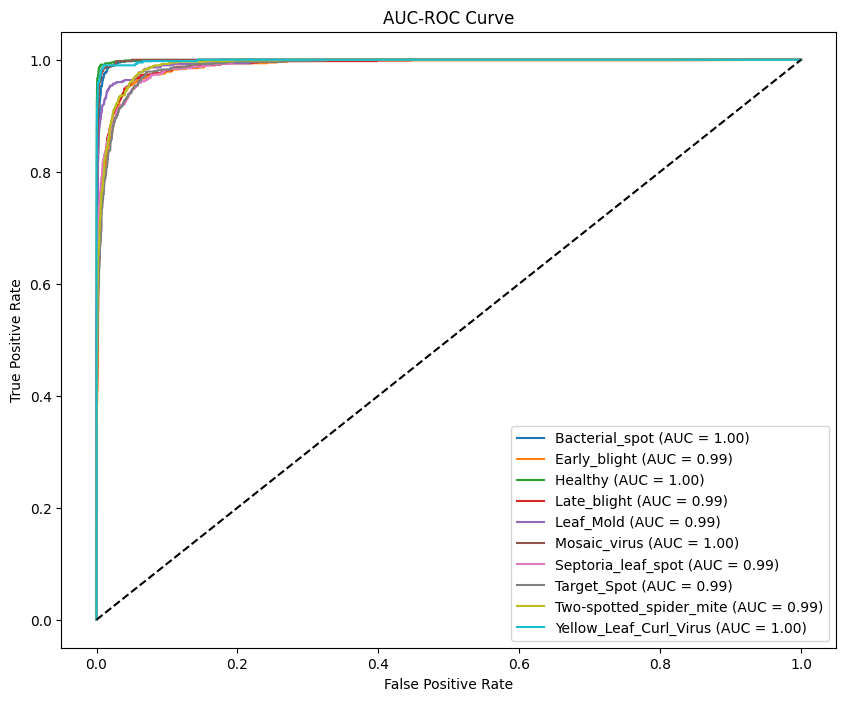

Trainable parameters: 521698
Non-trainable parameters: 0
Total training time: 116.95 minutes


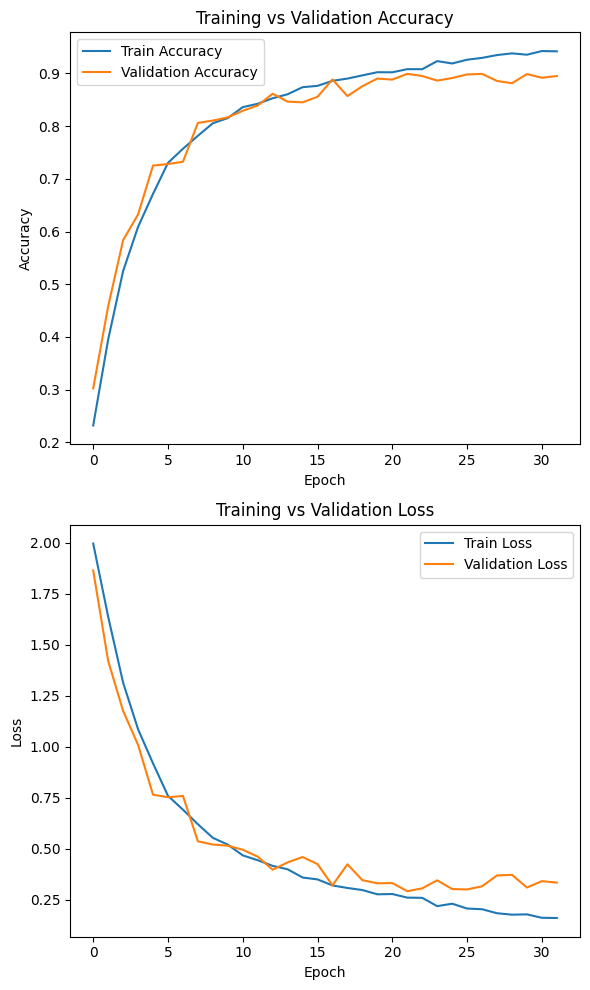

In [4]:
#Model Without L2 Regularization (CAL + Residuals retained, Dropout included)Tawawa
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress only the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import backend as K
# Dataset path and config
dataset_dir = "TomatoResizedCLAHE122Augmented4000"
img_size = (224, 224)
batch_size = 96
num_classes = 10
input_shape = (224, 224, 3)
# Data generators
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                              class_mode="categorical", subset="training", shuffle=True)
val_generator = datagen.flow_from_directory(dataset_dir, target_size=img_size, batch_size=batch_size,
                                            class_mode="categorical", subset="validation", shuffle=False)
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
from tensorflow.keras import layers, models

def attention_block(x):
    attn = layers.GlobalAveragePooling2D()(x)
    attn = layers.Dense(x.shape[-1] // 8, activation="relu")(attn)
    attn = layers.Dense(x.shape[-1], activation="sigmoid")(attn)
    return layers.Multiply()([x, attn])

def residual_block(x, filters):
    res = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    res = layers.Conv2D(filters, (3, 3), padding="same")(res)
    res = layers.Add()([x, res])
    return layers.Activation("relu")(res)

def model_without_regularization(input_shape=(224, 224, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    # Conv Block 2 + CAL
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 64)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Conv Block 3 + CAL
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 128)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Classification head (no L2)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)  # no kernel_regularizer
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model
model = model_without_regularization(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()

start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=200,
                    callbacks=[early_stopping, reduce_lr])
model.save("King Saaud Tomato\\CustomTomatoModelWithoutRegularization.h5")
training_time = time.time() - start_time
############################################################################
val_generator.reset()
val_pred = model.predict(val_generator, verbose=1)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
true_classes_binarized = label_binarize(true_classes, classes=range(num_classes))
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], val_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Parameter count
trainable_params = sum([K.count_params(p) for p in model.trainable_weights])
non_trainable_params = sum([K.count_params(p) for p in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")
print(f"Total training time: {training_time / 60:.2f} minutes")

# Plot Training and Validation Accuracy and Loss (Square-Shaped, Stacked Vertically)
def plot_training_curves(history):
    plt.figure(figsize=(6, 10))  # Narrower width for square appearance

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')


    
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Call the function
plot_training_curves(history)

Found 32000 images belonging to 10 classes.
Found 8000 images belonging to 10 classes.
Epoch 1/300
334/334 [==============================] - 146s 422ms/step - loss: 2.1030 - accuracy: 0.1904 - val_loss: 1.8210 - val_accuracy: 0.2994 - lr: 0.0010
Epoch 2/300
334/334 [==============================] - 122s 362ms/step - loss: 1.6682 - accuracy: 0.3818 - val_loss: 1.4125 - val_accuracy: 0.4896 - lr: 0.0010
Epoch 3/300
334/334 [==============================] - 142s 425ms/step - loss: 1.2723 - accuracy: 0.5336 - val_loss: 1.1180 - val_accuracy: 0.5947 - lr: 0.0010
Epoch 4/300
334/334 [==============================] - 223s 668ms/step - loss: 1.0890 - accuracy: 0.6120 - val_loss: 0.9666 - val_accuracy: 0.6586 - lr: 0.0010
Epoch 5/300
334/334 [==============================] - 223s 666ms/step - loss: 0.9511 - accuracy: 0.6622 - val_loss: 0.9153 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 6/300
334/334 [==============================] - 222s 662ms/step - loss: 0.8339 - accuracy: 0.7076 - val_lo

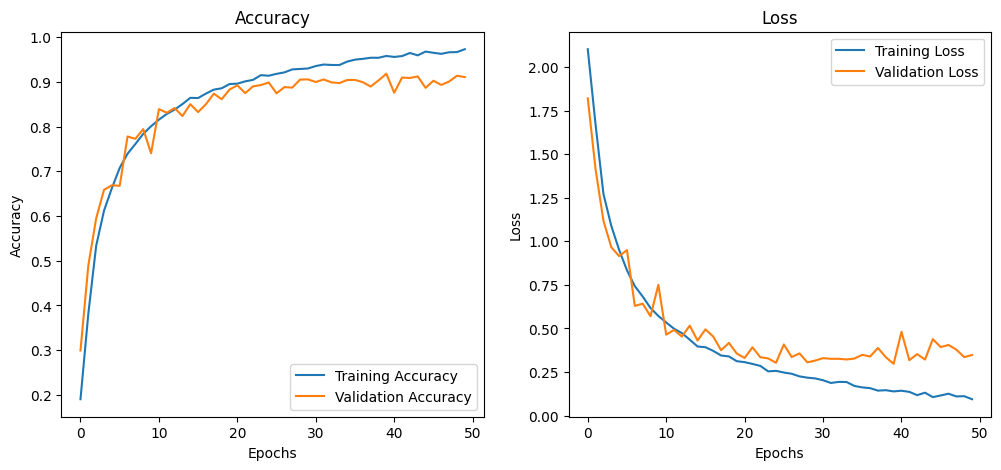

84/84 [==============================] - 24s 275ms/step

Classification Report:

                         precision    recall  f1-score   support

         Bacterial_spot       0.94      0.96      0.95       800
           Early_blight       0.87      0.84      0.85       800
                Healthy       0.95      0.99      0.97       800
            Late_blight       0.88      0.86      0.87       800
              Leaf_Mold       0.91      0.91      0.91       800
           Mosaic_virus       0.97      0.98      0.98       800
     Septoria_leaf_spot       0.91      0.87      0.89       800
            Target_Spot       0.88      0.87      0.87       800
Two-spotted_spider_mite       0.90      0.92      0.91       800
 Yellow_Leaf_Curl_Virus       0.96      0.98      0.97       800

               accuracy                           0.92      8000
              macro avg       0.92      0.92      0.92      8000
           weighted avg       0.92      0.92      0.92      8000



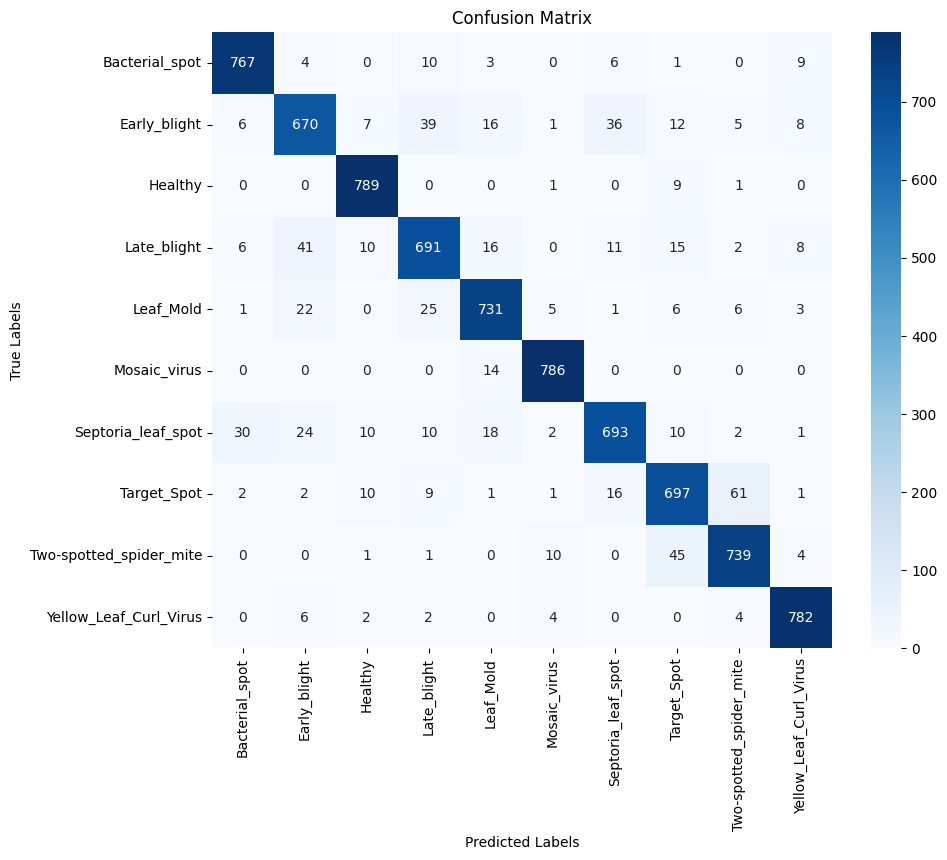

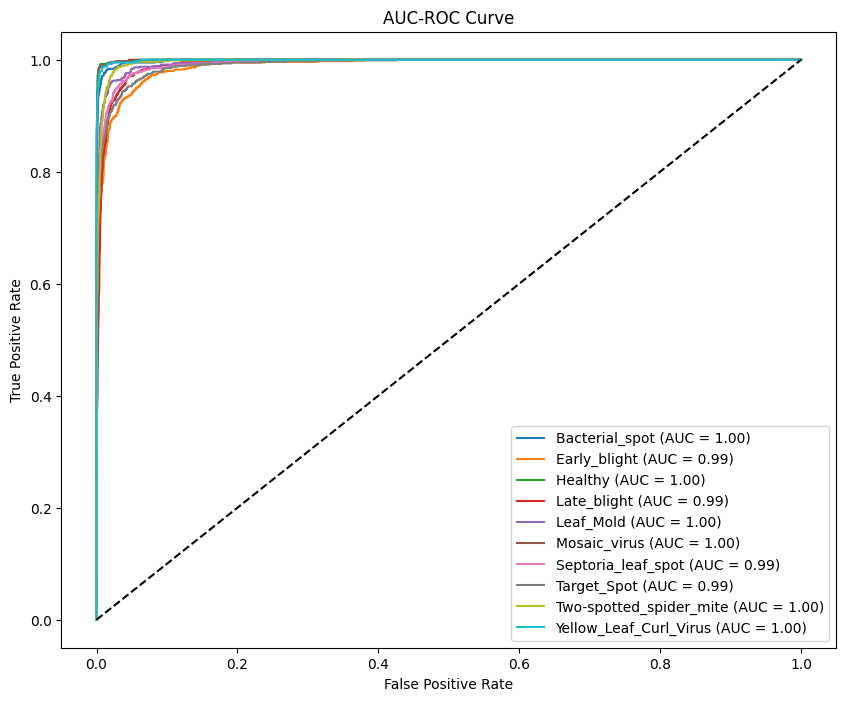

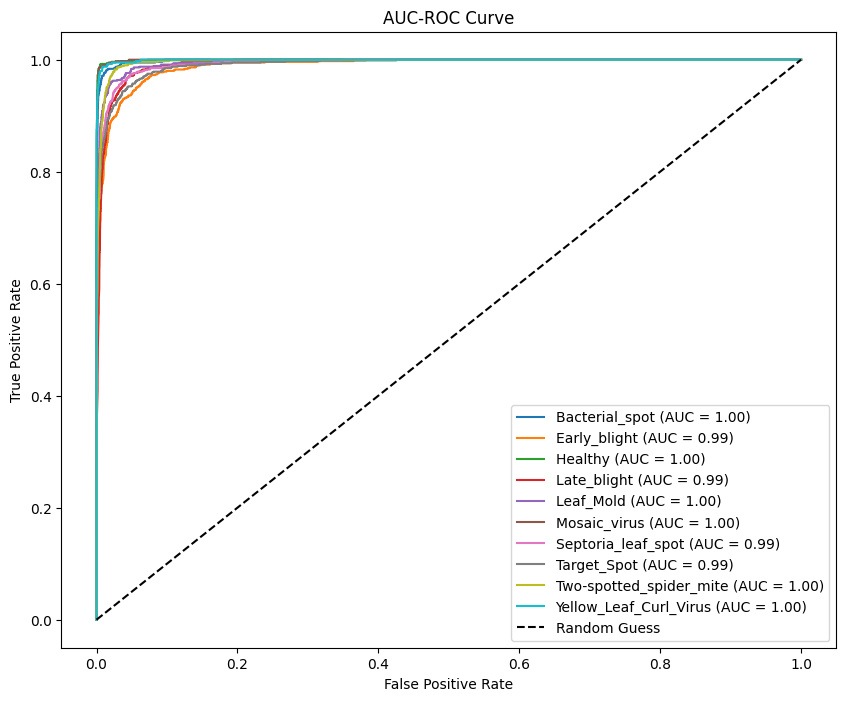

Total training time: 2.67 hours (160.15 minutes)
Trainable parameters: 521698
Non-trainable parameters: 0


In [4]:
#First fold Worked#104 bu  krdma 256#RGB
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
#Reduced regulriaztoinrate=0.0001 AND adding dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
#plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)
#########################################################################
#Without augmentation"TomatoresizedCLAHE122"#Fold-7#factor=0.1
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.00001)
#With a balanced #500 Epoch#2000 imgs in each class#factor=0.5#SGD
# Initialize the SGD optimizer
#optimizer = RMSprop( learning_rate=0.0001,rho=0.9,momentum=0.5, epsilon=1e-07)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define callbacks
early_stopping = EarlyStopping(    
    monitor='val_accuracy',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement to stop training
    restore_best_weights=True  # Restore model weights from the best epoch
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Factor by which the learning rate will be reduced
    patience=15,          # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6          # Lower bound on the learning rate
)
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Dataset Path
dataset_dir ="TomatoResizedCLAHE122Augmented4000"#"TomatoresizedCLAHE122"#"Tomatoresized"#"TomatoResizedCLAHE122Augmented2000"

# Data Generators with Validation Split
img_size = (224, 224)
batch_size = 96
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
)
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

def attention_block(x):
    attn = layers.GlobalAveragePooling2D()(x)
    attn = layers.Dense(x.shape[-1] // 8, activation="relu")(attn)
    attn = layers.Dense(x.shape[-1], activation="sigmoid")(attn)
    return layers.Multiply()([x, attn])

def residual_block(x, filters):
    res = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    res = layers.Conv2D(filters, (3, 3), padding="same")(res)
    res = layers.Add()([x, res])  # Residual connection
    return layers.Activation("relu")(res)

def simplified_model(input_shape=(224, 224, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # First Conv Block with Residual Connection
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second Conv Block with Attention
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 64)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Third Conv Block with Residual & Attention
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = residual_block(x, 128)
    x = attention_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Global Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.0001))(x)
    x = layers.Dropout(0.4)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

# Build Model
#model = simplified_model(input_shape=(224, 224, 3), num_classes=10)



# Build Model
num_classes = len(train_generator.class_indices)  # Dynamically determine number of classes
model = simplified_model(input_shape=(224, 224, 3), num_classes=num_classes)
# Record the start time
start_time = time.time()
# Train the Model
history = model.fit(train_generator,validation_data=val_generator,epochs=300,callbacks=[early_stopping, reduce_lr])
                    # Add the callbacks
model.save("King Saaud Tomato\\CustomTomatoModel2ndFold.h5")
# Record the end time
end_time = time.time()

# Calculate training time in seconds
training_time_seconds = end_time - start_time

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the Model
val_generator.reset()
val_pred = model.predict(val_generator, steps=len(val_generator), verbose=1)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# AUC-ROC Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_classes == i, val_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
####################################################
# ROC Curve for Multi-Class
from sklearn.preprocessing import label_binarize

# Binarize the true classes
true_classes_binarized = label_binarize(true_classes, classes=range(num_classes))
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], val_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {auc_score:.2f})")
# Plot the diagonal for reference
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
# Convert to hours
training_time_hours = training_time_seconds / 3600
# Convert to hours and minutes
training_time_minutes = training_time_seconds / 60
print(f"Total training time: {training_time_hours:.2f} hours ({training_time_minutes:.2f} minutes)")
from tensorflow.keras import backend as K
trainable_params = sum([K.count_params(p) for p in model.trainable_weights])
non_trainable_params = sum([K.count_params(p) for p in model.non_trainable_weights])
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")